In [1]:
import tomllib
from functools import partial

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as np
import matplotlib.pyplot as plt

from burst import (
    infft,
    segment_times,
    signal,
    simulate_complex,
    simulate_event,
)

%matplotlib inline

In [2]:
prng_key = jax.random.PRNGKey(0)

config = tomllib.load(open("sinegaussian_selection.toml", "rb"))

duration = config["duration"]
sample_rate = config["sample_rate"]
times = segment_times(duration, sample_rate)

population_size = config["svd"]["population_size"]

# Build a complex SVD basis for sine Gaussian singals

Simulate complex signals to model all possible phases with the phase parameter set to zero and no time offset.

Perform an SVD on this basis, filtering is then done as a multistage process:

- choose a subset of the basis with large eigenvalues to avoid overfitting noise.
- convolve the data with the real and imaginary components of the basis maximize over the unknown phase and time.
- realign the maximum time with zero.
- apply the filter.
- If the original time is important, realign the time back to the start point, otherwise leave it at zero.

In [3]:
keys = config["svd"].get("keys", config["bounds"].keys())

svd_bounds = {key: config["bounds"][key] for key in keys}

subkeys = jax.random.split(prng_key, population_size)
mean_frequency = 5.0
sigma_frequency = 20.0
signals = jax.vmap(partial(
    simulate_complex,
    mean_frequency=mean_frequency,
    sigma_frequency=sigma_frequency,
    bounds=svd_bounds,
    sample_rate=sample_rate,
    times=times,
))(np.array(subkeys))
signals = signals / np.sum(abs(signals)**2)**0.5

3.4416660252049396
5.538084711177775
3.7267619090477124
9.428714759184823
5.302772251767182
5.394758727832392
9.428512079860106
0.416967900954881
3.4836074114694924
6.461670749146652
5.941053048737149
3.1341823668750264
7.001497132934124
0.5195777492417414
7.819223795655261
4.121951793123589
3.3349261187126165
2.8619988322453813
5.346376992104012
3.1456870055928308
4.661945765537085
7.306444655517789
3.835755419530754
8.75198894946538
7.542126499832898
5.979441607618684
4.032134176067205
8.80436386353768
8.887692294594824
0.7133747118930855
5.316643573229968
3.1903655326001976
4.119428288059174
7.642636744579448
3.429655291134677
1.6270066448985991
1.4052941260879566
8.67596342258316
4.630143950306767
2.3005198831591587
3.4620836846365726
7.583689439260448
3.0534234609510778
8.508964460849999
5.595113908198327
9.26823499615572
6.964779889487698
3.5222879302127117
1.008587490561868
3.9480719111816676
5.265687626237102
7.915135460600413
7.612307991495072
1.4295806828041646
0.081071916261

In [4]:
u, s, v = np.linalg.svd(signals, full_matrices=False)
ur, sr, vr = np.linalg.svd(signals.real, full_matrices=False)
ui, si, vi = np.linalg.svd(signals.imag, full_matrices=False)
uri, sri, vri = np.linalg.svd(np.concat([signals.real, signals.imag]), full_matrices=False)
np.concat([signals.real, signals.imag]).shape, signals.shape

((2000, 1024), (1000, 1024))

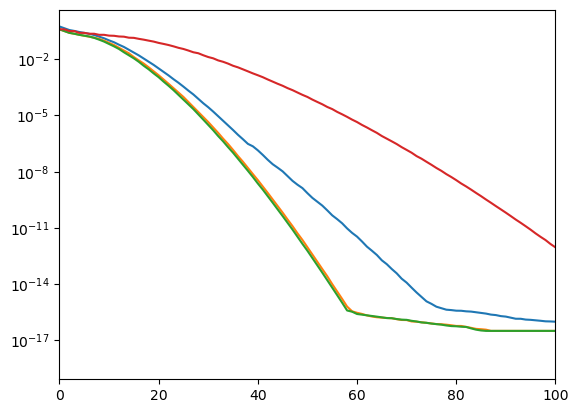

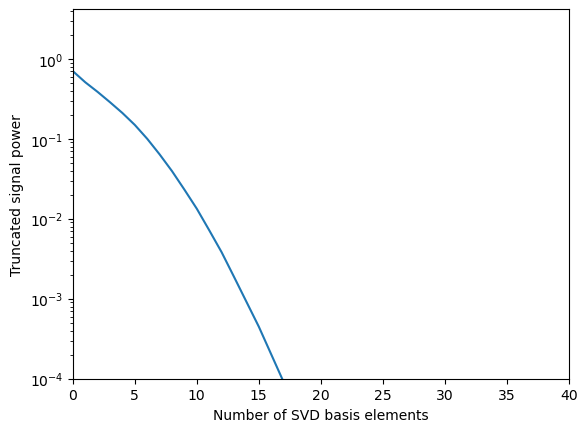

In [5]:
plt.plot(s)
plt.plot(sr)
plt.plot(si)
plt.plot(sri)
plt.yscale("log")
plt.xlim(0, 100)
plt.show()
plt.close()

plt.plot(1 - np.cumsum(s**2) / np.sum(s**2))
# plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of SVD basis elements")
plt.ylabel("Truncated signal power")
plt.ylim(1e-4)
plt.xlim(0, 40)
plt.show()
plt.close()

In [6]:
import dill

with open("sinegaussian_svd_250502.pkl", "wb") as ff:
    dill.dump((u, s, v), ff)

In [7]:
from burst import projection_matrix, load_basis

truncation = 20

basis, weights, projection = load_basis("sinegaussian_svd_250502.pkl", truncation=truncation)
# config["truncation"]
# weights = s
# basis = v
# projection = projection_matrix(basis[: 40], weights[:40], truncation=10)

(2000, 1024) (1024, 1024) (1024,) (1024,)
1174 1024
1174 1024
1174 1024
1174 1024


/Users/colmtalbot/mambaforge/envs/direct-inference/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/colmtalbot/mambaforge/envs/direct-inference/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


1174 1024


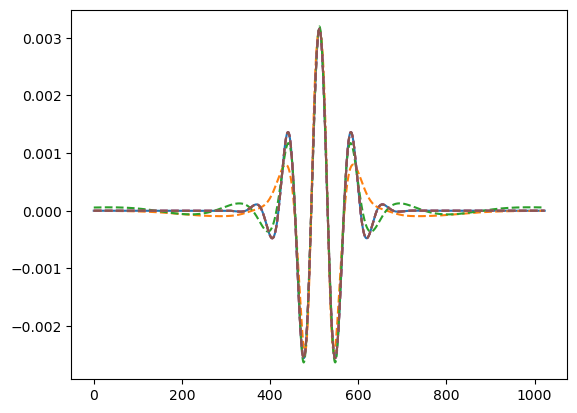

(Array(1174, dtype=int64),
 Array(1174, dtype=int64),
 Array(7.33086194e-11, dtype=float64),
 Array(9.6909509e-07, dtype=float64),
 Array(9.6909509e-07, dtype=float64),
 Array(9.6909509e-07, dtype=float64))

In [73]:
u, s, v = uri, sri, vri
print(u.shape, v.shape, s.shape, signals[0].shape)

temp = np.roll(signals[0], 150)

plt.plot(signals[0])

for truncation in [10, 20, 50, 100, 200, 500, 1000][:5]:

    U = s[:truncation, None] * jax.vmap(lambda mode: np.convolve(temp, mode, mode="full") / len(mode))(v[:truncation])
    # U = jax.vmap(lambda mode: np.convolve(temp, mode, mode="full") / len(mode))(v[:truncation])

    # plt.plot(abs((u[:, :truncation] * s[:truncation] @ U)[0]))
    # plt.plot((s[:truncation, None] * abs(U)**2).sum(axis=0) / 4)
    # print(U.shape)
    # shift = np.argmax((s[:truncation, None] * abs(U)**2).sum(axis=0) / 4)
    shift = np.argmax((abs(U)**2).sum(axis=0) / 4)
    pre_test = v[:truncation].T @ v[:truncation].conjugate()
    print(shift, len(temp))
    plt.plot(pre_test @ np.roll(temp, -shift), linestyle="--")
    # plt.plot(v[:truncation].T @ v[:truncation].conjugate() @ np.roll(temp, -shift), linestyle="--")
plt.show()
plt.close()

(
    np.argmax((s[:truncation, None] * abs(U)**2).sum(axis=0) / 4),
    np.argmax(abs((u[:, :truncation] * s[:truncation] @ U)[0])),
    (s[:truncation] * abs(v[:truncation].conjugate() @ signals[0] / len(signals[0]))**2).sum() / 4,
    abs((signals[0])**2).mean(),
    abs((v[:truncation].T @ v[:truncation].conjugate() @ np.roll(temp, -shift))**2).mean(),
    (abs(v[:truncation].conjugate() @ np.roll(temp, -shift))**2).sum() / len(temp),
)
# abs(v[:truncation] @ signals[0])

# U.shape

In [8]:

def apply_filter_multiple(data, projection, basis, time_align=True):
    """
    Apply the matched filter bank to multiple time series.

    This function maximizes optimal signal-to-noise ratio (SNR) for
    each time series over time shifts within a narrow window.

    After realigning the time series so that SNR peak is aligned
    the time series is projected against the basis functions.

    Parameters
    ----------
    data: ndarray
        The time series data to filter, shape
        (:code:`n_events`, :code:`duration * sample_rate`).
    projection: ndarray
        The projection matrix, see :func:`projection_matrix`, shape
        (:code:`n_time_shift_filters`, :code:`time_window`,
        :code:`duration * sample_rate`).
    basis: ndarray
        The basis functions, shape
        (:code:`n_filters`, :code:`duration * sample_rate`).
    time_align: bool
        Whether to time-align the data to the SNR peak, default is True.

    Returns
    -------
    filtered: ndarray
        The filtered time series, shape (:code:`n_events`, :code:`n_filters`).
    snr: ndarray
        The optimal signal-to-noise ratio of the filtered time series, shape
        (:code:`n_events`,).
    delta: ndarray
        The time shift (in number of indices) that maximizes the signal-to-noise
        ratio, shape (:code:`n_events`,).
    """
    if time_align:
        import jax
        def func(carry, x):
            basis, temp = carry
            val = jax.lax.dynamic_slice_in_dim(temp, x, basis.shape[-1], axis=0)
            snr = (abs(basis @ val)**2).sum()**0.5
            return carry, snr
        new_shape = (50, *data.shape[1:])
        temp = np.concatenate([np.zeros(new_shape), data, np.zeros(new_shape)])
        _, snr_time_series = jax.lax.scan(func, (basis, temp), np.arange(len(temp) - basis.shape[-1]))
        delta = np.atleast_1d(-np.argmax(snr_time_series, axis=0) + 50)
        data = jax.vmap(np.roll, in_axes=(1, 0))(data, delta).T
    else:
        delta = 0
    filtered = basis.conjugate() @ data
    snr = (abs(filtered) ** 2).sum(axis=0) / len(data)
    # snr = (basis.T @ filtered).sum()
    # snr = 2 * (basis.T @ filtered.conjugate() * data).sum(axis=0) / len(data)
    # snr = (filtered).sum(axis=0) / len(data)
    # print(snr)
    # filtered = (filtered * np.exp(-1j * np.angle(snr))).real
    # filtered = filtered.real
    return filtered, abs(snr)**0.5, delta

5.068533545407565
[-5] BurstParameters(frequency=Array(5.06853355, dtype=float64), amplitude=Array(54.13206832, dtype=float64), bandwidth=Array(0.49279252, dtype=float64), phase=Array(1.9472252, dtype=float64), delta_t=Array(0., dtype=float64, weak_type=True))
4.176027650466785
[-6] BurstParameters(frequency=Array(4.17602765, dtype=float64), amplitude=Array(44.95854172, dtype=float64), bandwidth=Array(0.50934046, dtype=float64), phase=Array(0.32738401, dtype=float64), delta_t=Array(0., dtype=float64, weak_type=True))
5.40328105264016
[42] BurstParameters(frequency=Array(5.40328105, dtype=float64), amplitude=Array(51.98342546, dtype=float64), bandwidth=Array(0.48775565, dtype=float64), phase=Array(1.51012819, dtype=float64), delta_t=Array(0., dtype=float64, weak_type=True))
5.016890423018805
[-45] BurstParameters(frequency=Array(5.01689042, dtype=float64), amplitude=Array(51.82649353, dtype=float64), bandwidth=Array(0.49269913, dtype=float64), phase=Array(2.72978964, dtype=float64), del

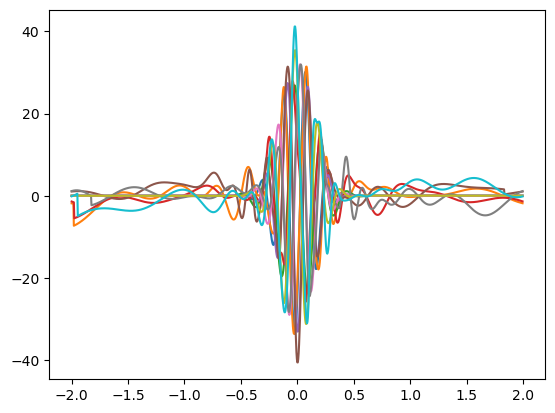

In [12]:
from numpy import random

test_bounds = dict(
    amplitude=(50, 5),
    frequency=(5, 0.2),
    bandwidth=(0.5, 0.01),
    phase=(0, np.pi),
    # delta_t=(0, 0.01),
)
for _ in range(5):
    fd_data, parameters = simulate_event(
        jax.random.PRNGKey(random.randint(0, 2**32)),
        5.0,
        0.5,
        bounds=test_bounds,
        sample_rate=sample_rate,
        duration=duration,
        times=times
    )
    sig = signal(parameters, times=times, sample_rate=sample_rate).squeeze()
    new_data = infft(fd_data, sample_rate=sample_rate)

    from utils import apply_filter_multiple

    basis2 = weights[:, None] * basis

    filtered, _, delta = apply_filter_multiple(np.atleast_2d(new_data).T, projection, basis, time_align=True)
    # filtered = filtered.squeeze()
    # filtered = basis.conjugate() @ filtered
    # filtered @= basis
    # filtered = sum(s[:truncation]) * np.roll((filtered.squeeze() * s[:truncation]) @ basis, -delta)
    # filtered = np.roll((filtered.squeeze() * weights) @ basis, -delta) * sum(weights)
    filtered = 2 * np.roll((filtered.squeeze()) @ basis, -delta)
    # reconstructed = v.T[:, :truncation] * s[:truncation] @ filtered
    # print(filtered.shape)
    # plt.plot(times, new_data + filtered, alpha=0.3)
    # plt.plot(times, (filtered.real - sig) / max(sig))
    plt.plot(times, sig)
    plt.plot(times, filtered.real)
    print(delta, parameters)
plt.show()
plt.close()

In [39]:
filtered.shape, s.shape, basis.shape, sum(s[:truncation]), sum(s[:truncation]**2)**0.5

((1024,),
 (1024,),
 (50, 1024),
 Array(4.53963708, dtype=float64),
 Array(0.99999999, dtype=float64))

4.703062291460468


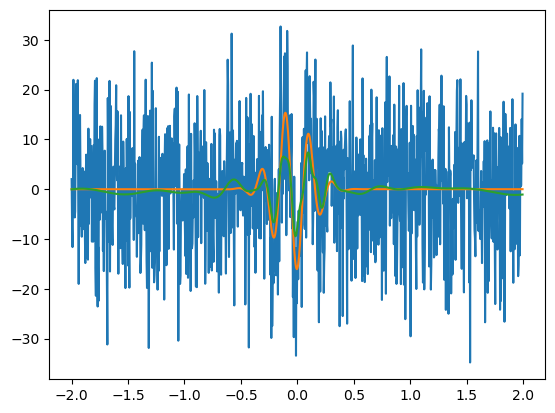

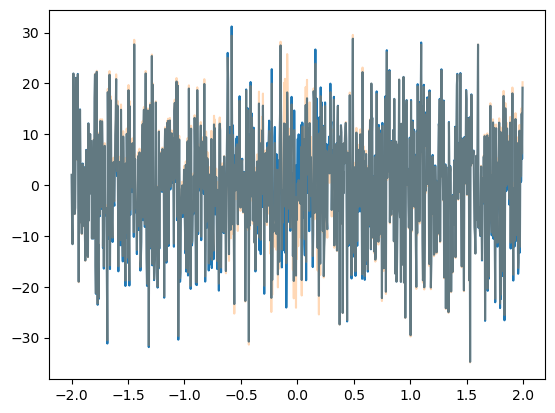

(20, 1) (1024,) [3.74435666]


/Users/colmtalbot/mambaforge/envs/direct-inference/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/colmtalbot/mambaforge/envs/direct-inference/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


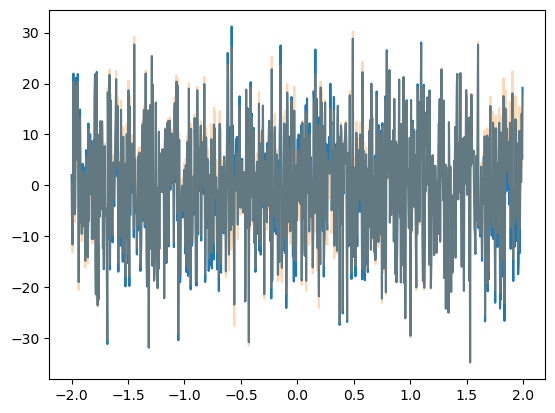

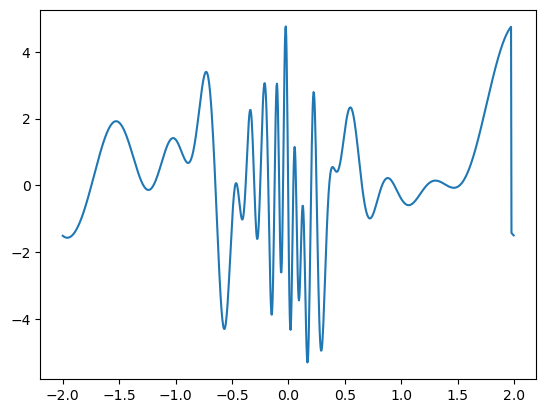

0.02672953439151386


In [13]:
test_bounds = dict(
    amplitude=(10, 30),
    frequency=(1, 9),
    bandwidth=(0.3, 0.7),
    phase=(0, np.pi),
    delta_t=(0.1, 0.3),
)
fd_data, parameters = simulate_event(
    jax.random.PRNGKey(5),
    5.0,
    0.5,
    bounds=test_bounds,
    sample_rate=sample_rate,
    duration=duration,
    times=times
)
sig = signal(parameters, times=times, sample_rate=sample_rate).squeeze()
new_data = infft(fd_data, sample_rate=sample_rate)
# new_data = sig

# truncation = 8
# truncation = 8
# projection = projection_matrix(basis[:truncation], weights[:truncation], truncation=min(truncation, 10))

# basis = v[:truncation]

plt.plot(times, new_data)
plt.plot(times, sig)
# for n_templates in [5, 10, 20, 40]:
#     filter = v[:n_templates]
plt.plot(times, (basis @ new_data @ basis.conjugate()).real)
plt.show()
plt.close()


plt.plot(times, new_data - sig)
# for n_templates in [5, 10, 20, 40]:
#     filter = v[:n_templates]
plt.plot(times, new_data - (basis @ new_data @ basis.conjugate()).real, alpha=0.3)
plt.show()
plt.close()


# weights = s[:truncation, None]


from utils import apply_filter_multiple


def time_align(data):
    shift = len(data) // 2 - np.argmax(data)
    return np.roll(data, shift)


plt.plot(times, new_data - sig)
# for n_templates in [5, 10, 20, 40]:
#     filter = v[:n_templates]
filtered, snr, delta = apply_filter_multiple(new_data[:, None], projection, basis, time_align=True)
print(filtered.shape, new_data.shape, snr)
reconstructed = 2 * np.roll(filtered.squeeze() @ basis, -delta)
plt.plot(times, new_data - reconstructed, alpha=0.3)
plt.show()
plt.close()

plt.plot(times, sig - reconstructed)
plt.show()
plt.close()

print(np.sum(abs(reconstructed.real - sig)**2) / np.sum(abs(new_data - sig)**2))

# # for n_templates in [5, 10, 20, 40]:
# #     filter = v[:n_templates]
# filtered = apply_filter(new_data, basis, weights)
# plt.plot(times, time_align(filtered))
# plt.show()
# plt.close()

4.71075174204198
5.289061873287086
5.293659393569373
5.076263745239702
4.841636277437572
5.672220322127613
5.4557473945245105
5.090969171012942
5.809338141310061
4.917860643891505
5.2260666417317205
5.6336606852559035
5.265874324876691
4.256482953690989
5.290907623657347
5.13226809050332
4.754978866738657
5.769978666185553
4.800458320122541
4.593743593067288
4.683127963076537
5.40313197908225
4.932468328432149
5.268643944578443
4.646346430000808
4.6816437912445625
5.190623207776334
6.088772551616603
4.441475677922134
4.335356356443589
4.561837744031514
5.339059240907078
4.590982895645755
5.5285738635114265
4.615092302504771
4.752007373008157
4.9851334414591735
4.762430346545244
4.450846257936191
4.35511782271307
5.5983062902381775
4.991206615725438
6.201421643336743
6.0875305377176305
4.413738750156392
5.425235605173919
4.509297406572517
5.884094066148763
5.720823198061936
4.970710911008099


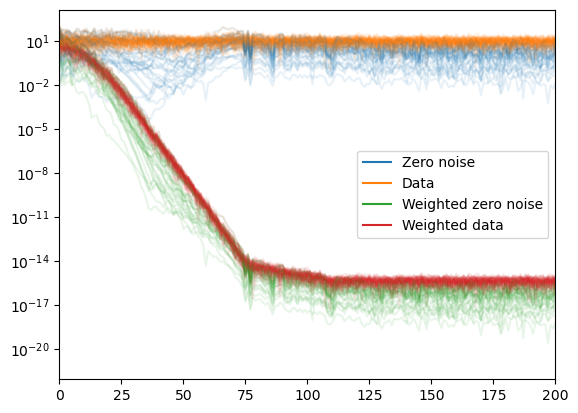

Array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
      

In [45]:
rng_key = jax.random.PRNGKey(0)
for _ in range(50):
    rng_key, subkey = jax.random.split(rng_key)
    fd_data, parameters = simulate_event(
        subkey,
        5.0,
        0.5,
        bounds=test_bounds,
        sample_rate=sample_rate,
        duration=duration,
        times=times
    )
    sig = signal(parameters, times=times, sample_rate=sample_rate).squeeze()
    new_data = infft(fd_data, sample_rate=sample_rate)

    compressed_signal = v @ sig
    compressed_data = v @ new_data
    plt.plot(abs(compressed_signal), alpha=0.1, color="C0")
    plt.plot(abs(compressed_data), alpha=0.1, color="C1")
    plt.plot(s * abs(compressed_signal), alpha=0.1, color="C2")
    plt.plot(s * abs(compressed_data), alpha=0.1, color="C3")
plt.axvline(-1, color="C0", label="Zero noise")
plt.axvline(-1, color="C1", label="Data")
plt.axvline(-1, color="C2", label="Weighted zero noise")
plt.axvline(-1, color="C3", label="Weighted data")
plt.yscale("log")
plt.xlim(0, 200)
plt.xlabel("Basis number")
plt.ylabel("Power")
plt.legend(loc="center right")
# plt.ylim(1e-4, 1e2)
plt.show()
plt.close()

np.cumsum(compressed_data.conjugate() * s**2 * compressed_signal)**0.5

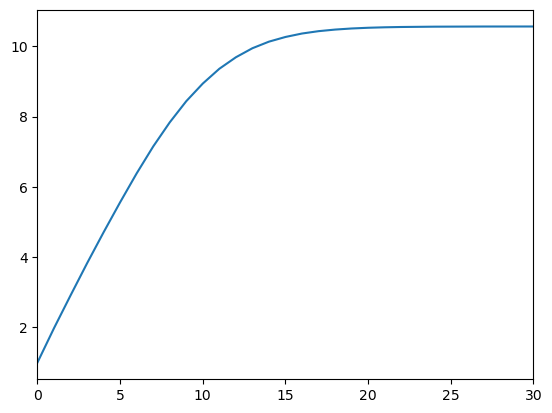

In [42]:
plt.plot(np.cumsum(s)**2 / np.cumsum(s**2))
plt.xlim(0, 30)
plt.show()
plt.close()